# Model inference

In [3]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

save_directory = os.path.expanduser("~/scratch/npys/") # or in "~/work/"
save_path = os.path.join(save_directory, "save_name")

feynmangpu04.cluster.local
gpu [cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import and simulate fiducial

In [2]:
from montecosmo.models import forward_model, model_kwargs
model_kwargs['scale_factor_lpt'] = 0.5
model_kwargs['scale_factor_obs'] = 0.5
print(f"{model_kwargs=}")

# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

# Condition model on some cosmology and sample
fiducial_cosmo_params_base = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, fiducial_cosmo_params_base) # NOTE: Only condition on random sites, not deterministic ones
fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)

# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_model_trace[var_name]['value'] for var_name in cosmo_var_names}
from jax_cosmo import Planck15
fiducial_cosmology = Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

model_kwargs={'mesh_size': array([64, 64, 64]), 'box_size': array([64, 64, 64]), 'scale_factor_lpt': 0.5, 'scale_factor_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': False}


2023-12-16 19:35:41.787323: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


## Run inference

In [12]:
# Condition model
obs_var_names = ['obs_mesh'] # NOTE: Only condition on random sites
obs_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in obs_var_names}
observed_model = condition(forward_model, obs_values)  

# Initialize sampler
init_var_names = ['Omega_c_base', 'sigma8_base', 'init_mesh_base'] # NOTE: Only init on random sites
init_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in init_var_names}

# # Load some inverse mass matrix
# with open(save_path+f"_invM.p", 'rb') as file:
#     variance_as_invM = pickle.load(file)

nuts_kernel = numpyro.infer.NUTS(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    # inverse_mass_matrix=variance_as_invM, 
    adapt_mass_matrix=False,
    # dense_mass=[('Omega_c_base', 'sigma8_base')], # NOTE: dense matrix for cosmo params joint, diagonal for the rest
    # step_size=0.01, 
    # adapt_step_size=False,
    max_tree_depth=5,)

hmc_kernel = numpyro.infer.HMC(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    # adapt_mass_matrix=False,
    step_size=1e-40, 
    # adapt_step_size=False,
    num_steps=1,)

# Propose MALA step size based on Chen+2019 http://arxiv.org/abs/1801.02309
L_smoothness, m_strong_convex = 1, 1 # log density regularity properties
condition_number = L_smoothness / m_strong_convex
print(f"MALA step size proposal={1 / (L_smoothness * (model_kwargs["mesh_size"].prod() * condition_number)**0.5):e}")

from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm
mala_kernel = MetropolisAdjustedLangevinAlgorithm(model=observed_model,
                                                  init_strategy=numpyro.infer.init_to_value(values=init_values),
                                                  step_size=0.001,)

mcmc = numpyro.infer.MCMC(
    sampler=hmc_kernel,
    num_warmup=5000,
    num_samples=5000, # for each run
    # num_chains=4,
#    chain_method="vectorized", 
    progress_bar=True,)

MALA step size proposal=1.953125e-03


In [ ]:
from montecosmo.utils import sample_and_save
# Variables to save
save_var_names = cosmo_var_names + ['Omega_c_base', 'sigma8_base', 'init_mesh']
extra_fields = ['num_steps'] # e.g. 'num_steps'

mcmc_runned = sample_and_save(mcmc, model_kwargs, 2, save_path, save_var_names, extra_fields=extra_fields)

run 0/5 (warmup)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
  0%|          | 0/5000 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return geta

## Analysis

In [ ]:
from montecosmo.utils import load_runs

start_run, end_run = 0, 2
# Load only cosmological samples
cosmo_post_samples = load_runs(start_run, end_run, save_path, cosmo_var_names)
cosmo_post_samples_arr = np.array(list(cosmo_post_samples.values())).T
# Load saved samples
post_samples = load_runs(start_run, end_run, save_path, save_var_names)
# Load extra fields
post_extra_fields = load_runs(start_run, end_run, save_path+"_extra", extra_fields)
n_eval = int(post_extra_fields['num_steps'].sum())
print(f"total {n_eval=}")

loading: obs_lpt32__ss1em40__ns1__mmfree_HMC
total run length=900
total run length=900
total run length=900
total n_eval=900


### Chain

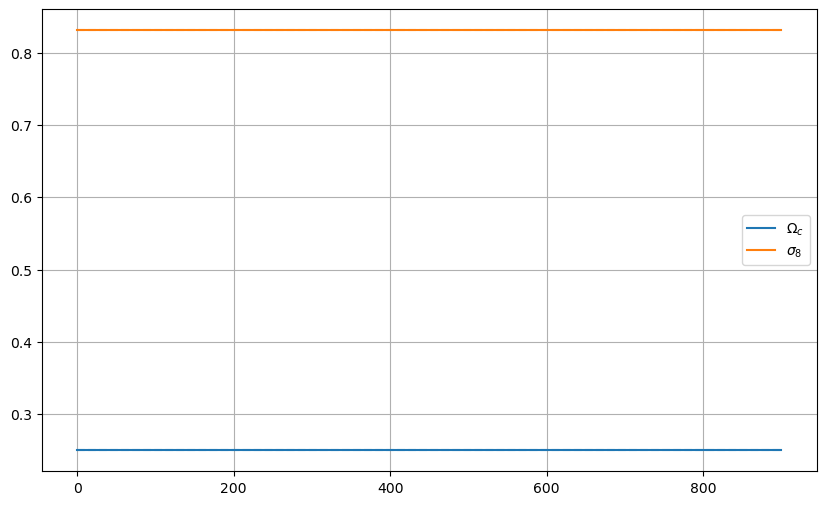

In [ ]:
# Plot chain
plt.figure(figsize=(10,6))
plt.plot(cosmo_post_samples_arr, label=["$"+label+"$" for label in cosmo_var_labels])
plt.hlines(fiducial_cosmo_params.values(), 
           xmin=0, xmax=len(cosmo_post_samples_arr), 
           ls="--", alpha=0.5,
           color=["C"+str(i) for i in range(len(cosmo_post_samples_arr))],)
plt.legend(), plt.grid(), 
plt.savefig(save_path+"_chain")
plt.show()

Removed no burn in
Removed no burn in


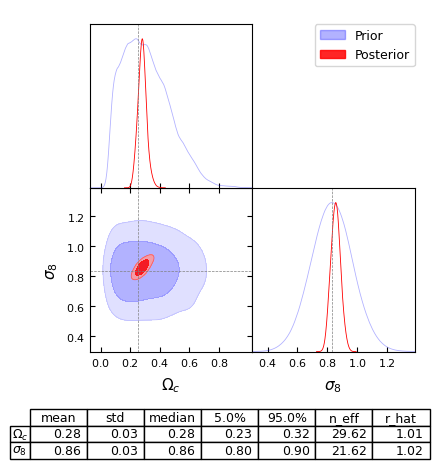

In [ ]:
# Diagnostics
# numpyro.diagnostics.print_summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains
summary_dic = numpyro.diagnostics.summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains
summary_arr = [list(list(summary_dic.values())[i].values()) for i in range(len(summary_dic.values()))]

# Define a custom formatting function to vectorize on summary array
def format_value(value):
    return f"{value:0.2f}"

# Sample from prior
from montecosmo.bricks import cosmo_prior
def cosmo_prior_plate(plate_size):
    with numpyro.plate('cosmo_prior_plate', plate_size):
        cosmo_prior(trace_reparam=True)

plate_size = 10000
cosmo_prior_trace = trace(seed(cosmo_prior_plate, 0)).get_trace(plate_size)
cosmo_prior_samples_arr = np.array([cosmo_prior_trace[key]['value'] for key in cosmo_var_names]).T

# Triangle plot
post_samples_gd = MCSamples(samples=cosmo_post_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
prior_samples_gd = MCSamples(samples=cosmo_prior_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
gd = plots.get_subplot_plotter(subplot_size=None)
# gd.settings.solid_colors='tab10_r'
gd.triangle_plot(roots=[prior_samples_gd, post_samples_gd],
                 markers=fiducial_cosmo_params,
                 filled=True, 
                 legend_labels=["Prior", "Posterior"],
                 line_args=[{'color':'b', 'alpha':0.3},{'color':'r'}],
                 contour_args=[{'color':'b', 'alpha':0.3},{'color':'r'}],)

# Plot summary table
plt.subplot(position=[0,0,1,1]), plt.axis('off')
# gd.fig.axes[-1]('tight'), plt.axis('tight'), plt.subplots_adjust(top=2), plt.gcf().patch.set_visible(False), 
plt.table(cellText=np.vectorize(format_value)(summary_arr),
            # rowLabels=list(summary_dic.keys()),
            rowLabels=["$"+label+"$" for label in cosmo_var_labels], 
            colLabels=list(list(summary_dic.values())[0].keys()),)
plt.savefig(save_path+"_triangle", bbox_inches='tight') # NOTE: tight bbox required to save table
plt.show();

### Mass matrix

In [ ]:
# Load mass matrix
import pickle
with open(save_path+f"_laststate.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

6.9071e-35 {('Omega_c_base', 'init_mesh_base', 'sigma8_base'): Array([4.761905e-05, 4.761905e-05, 4.761905e-05, ..., 4.761905e-05,
       4.761905e-05, 4.761905e-05], dtype=float32)}


In [ ]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    var_variance = post_samples[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_base']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,4))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend(), plt.grid()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_base")
plt.legend(), plt.tight_layout(), plt.grid()
plt.savefig(save_path+"_invMvar");

In [ ]:
# Save posterior variance as inverse mass matrix format
post_variance = []
for var_name in var_names:
    if var_name == 'init_mesh_base':
        var_name = 'init_mesh'
        post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
    else:
        post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
        post_variance = np.concatenate((post_variance, ))
variance_as_invM = {var_names: post_variance}
print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

### Init. cond. 

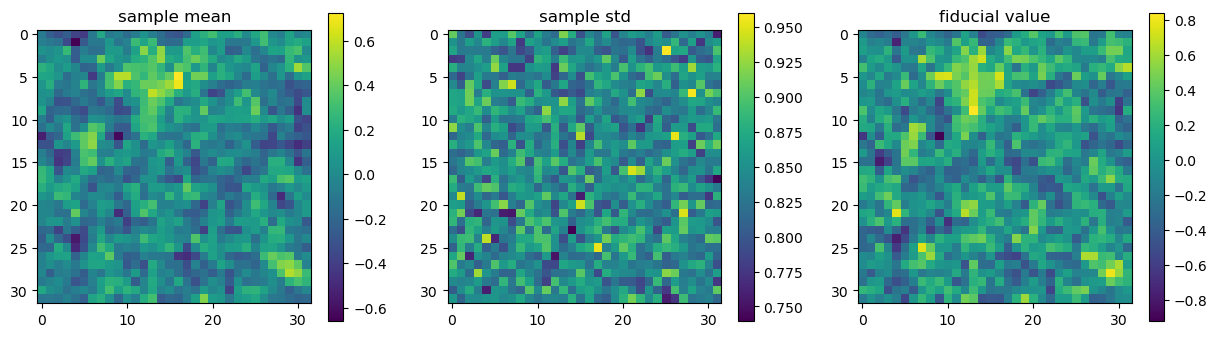

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_model_trace['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();

### Spectrum distribution

In [ ]:
from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get meshes from model trace
init_mesh = fiducial_model_trace['init_mesh']['value']
biased_mesh = fiducial_model_trace['biased_mesh']['value']
obs_mesh = fiducial_model_trace['obs_mesh']['value']
# Get other meshes from model trace particles, compensate for CIC painting convolution
zeros_mesh = jnp.zeros(model_kwargs['mesh_size'])
lpt_mesh = cic_paint(zeros_mesh, fiducial_model_trace['lpt_part']['value'])
rsd_mesh = cic_paint(zeros_mesh, fiducial_model_trace['rsd_part']['value'])

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
pk_lin_obs = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_obs'])

pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_lpt = power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_rsd = power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_biased = power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

In [ ]:
n_pks = 1000
pks = np.empty((n_pks, *pk_init[1].shape))
for i_sample in range(n_pks):
    mesh = post_samples['init_mesh'][-i_sample]
    _, pks[i_sample] = power_spectrum(mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

pk_023, pk_159, pk_500, pk_841, pk_977 = np.quantile(pks, q=[0.023, 0.159, 0.5, 0.841, 0.977], axis=0)

NameError: name 'pk_init' is not defined

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


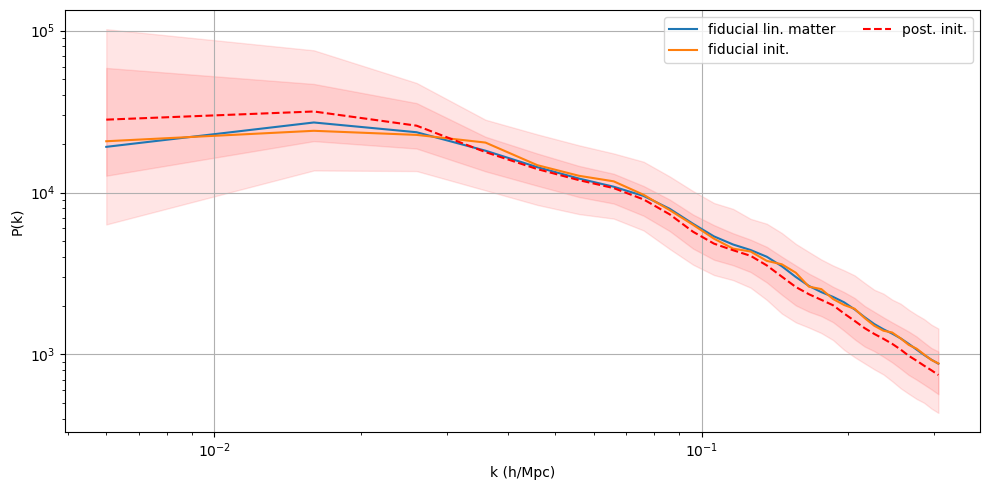

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"fiducial lin. matter")
plt.loglog(pk_init[0], pk_init[1], label=f"fiducial init.")
plt.loglog(pk_init[0], pk_500, color='red', ls='--', label=f"post. init.")
plt.fill_between(pk_init[0], pk_159, pk_841, alpha=0.1, color='red')
plt.fill_between(pk_init[0], pk_023, pk_977, alpha=0.1, color='red')
plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.grid(), plt.tight_layout()
plt.savefig(save_path+"_Pkdist");